# RAG Implementation with AzureOpenAI and LangChain

In [49]:
!python -m pip install langchain-community langchainhub langchain-chroma langchain langchain-experimental --quiet

In [50]:
!python -m pip install pypdf faiss-cpu --quiet

In [51]:
import os

embedding_model_name = "text-embedding-3-small"
model_name = "gpt4o"

In [52]:
doc_paths = ["https://www.morningstar.com/content/dam/marketing/shared/research/methodology/771945_Morningstar_Rating_for_Funds_Methodology.pdf",
             "https://www.morningstar.in/docs/methodology/CategoryDefinitionsIndiaV3.pdf",
             "https://s21.q4cdn.com/198919461/files/doc_downloads/press_kits/2016/Morningstar-Sustainable-Investing-Handbook.pdf"]

In [53]:
from langchain_community.document_loaders import PyPDFLoader

#loaders = [PyPDFLoader(pdf, extract_images=False,mode='single') for pdf in doc_paths]
loaders = [PyPDFLoader(pdf, extract_images=False) for pdf in doc_paths]
docs = []

for loader in loaders:
    doc = loader.load()
    docs.extend(doc)

In [54]:
len(docs)

46

In [55]:
docs[0]

Document(metadata={'producer': 'Adobe PDF Library 15.0', 'creator': 'Adobe InDesign 15.0 (Macintosh)', 'creationdate': '2021-08-26T06:25:29-04:00', 'moddate': '2021-08-26T06:25:33-04:00', 'trapped': '/False', 'source': 'https://www.morningstar.com/content/dam/marketing/shared/research/methodology/771945_Morningstar_Rating_for_Funds_Methodology.pdf', 'total_pages': 21, 'page': 0, 'page_label': '1'}, page_content='The Morningstar Rating\nTM\n for Funds\nMorningstar Methodology\nAugust 2021\nContents\nIntroduction \nMorningstar Categories \nTheory \nCalculations \nThe Morningstar Rating: \nThree-, Five-, and 10-Year \nMorningstar Return and \nMorningstar Risk Rating\nThe Overall Morningstar Rating\nRating Suspensions\nConclusion\nAppendix 1: Risk-Free Rates Applied\nAppendix 2: Methodology Changes\nAppendix 3: Star Ratings for Separately\nManaged Accounts and Models\nImportant Disclosure\nMerged with the existing star rating\nThe conduct of Morningstar’s analysts is governed \nby Code of 

In [56]:
# drop pages which have less than 100 characters (e.g. header pages, empty separater pages)
docs = [doc for doc in docs if len(doc.page_content.strip())>100]
len(docs)

45

In [33]:
# FOr all remaining document, checking the average characters count
sum(len(doc.page_content) for doc in docs)/len(docs)

2707.9555555555557

In [58]:
2707*1.5

4060.5

In [59]:
# split the documents(each pdf page as one document) , into multiple so that at max there are 3500 characters in one document, with overlap of 500 characters while splitting
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=3500, chunk_overlap=500)
splits = text_splitter.split_documents(docs)
len(splits)

53

In [60]:
print(splits[1].page_content)

3
3
3
©2021 Morningstar, Inc. All rights reserved. The information in this document is the property of Morningstar, Inc. Reproduction or transcription by any means, in whole or in part, without the prior written 
consent of Morningstar, Inc., is prohibited.
 
The Morningstar RatingTM for Funds    August 2021Page 2 of 21
captured by standard deviation, as would be the case if excess return were normally or lognormally 
distributed, which is not always the case. Also, standard deviation measures variation both above 
and below the mean equally. But investors are generally risk-averse and dislike downside variation 
more than upside variation. Morningstar gives more weight to downside variation when calculating 
Morningstar Risk-Adjusted Return and does not make any assumptions about the distribution of 
excess returns.
The other commonly accepted meaning of “risk-adjusted” is based on assumed investor preferences. 
Under this approach, higher return is “good” and higher risk is “bad” und

In [ ]:
from langchain_openai import AzureOpenAIEmbeddings
embeddings = AzureOpenAIEmbeddings(model=embedding_model_name,
                                   azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"])

In [62]:
# initializng the vector store using CHromaDB
#from langchain_community.vectorstores import FAISS
#from langchain.embeddings import HuggingFaceBgeEmbeddings
#embedding_model_name = "BAAI/bge-large-en-v1.5"
#embeddings = HuggingFaceBgeEmbeddings(model_name=embedding_model_name,)

In [64]:
import os
vector_db_path = "VectorDB_Chroma"
os.makedirs(vector_db_path,exist_ok=True)

In [66]:
from langchain_chroma import Chroma
vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings,
                                    persist_directory=vector_db_path,collection_name="morningstar2",
                                    collection_metadata={"use_type":"TRAINING AND EXPERIMENTATION"})


In [67]:
print("Number of docs dumped into vector DB")
print(len(vectorstore.get()['ids']))

Number of docs dumped into vector DB
53


In [89]:
# using vector db object to initialize a retriever object - to perform vector search/retrieval
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 2})

In [90]:
retrieved_docs = retriever.invoke("What is Monrning Star Suistainable Rating?")
len(retrieved_docs)

2

In [74]:
print(retrieved_docs[0])


page_content='The Morningstar Sustainable Investing Handbook
7
Is interest in sustainable investing really growing? 
Investors are placing increasing importance on sustainability issues. In a 2015 survey, the Morgan 
Stanley Institute of Sustainable Investing found that 71% of individual investors are interested  
in sustainable investing. During 2015, the number of financial institutions that signed the United 
Nations-backed Principles for Responsible Investment (PRI) Initiative increased by 29%. As of 
January 2016, nearly 1,500 firms managing in excess of $59 trillion have joined this global network 
of investors working to promote responsible investing.
Why are investors increasingly interested in integrating ESG factors into 
their investment decisions?
Some investors want to know they are investing in companies with strong sustainable practices 
and ethical policies. It’s a way of aligning their investments with their values. Others see ESG  
as a set of factors often overlooked

In [75]:
ret_docs = vectorstore.similarity_search_with_score("What is Large Cap equity fund",k=2)
print(ret_docs[0])

(Document(id='2971241b-b336-4b94-90be-f988a53abc5e', metadata={'page_label': '1', 'total_pages': 12, 'producer': 'GPL Ghostscript 9.06', 'title': 'Microsoft Word - India Category_Definitions April 2021', 'author': 'KBelapu', 'creationdate': '2021-02-26T12:11:18+05:30', 'source': 'https://www.morningstar.in/docs/methodology/CategoryDefinitionsIndiaV3.pdf', 'creator': 'PScript5.dll Version 5.2.2', 'page': 0, 'moddate': '2021-02-26T12:11:18+05:30'}, page_content='? \n \n \n \n \n \n \n \n \n \n \n \nCategor y Definitions  \nIndia \nEquity  \n \nLarge-Cap \nLarge-Cap funds primarily consist of stocks which are the Top 100 stocks by full market capitalization  of \nthe equity market. These funds invest at least 80% of total assets in Indian equities and the balance can \nbe invested in other asset classes such as fixed income and overseas equities, among others. Funds in \nthis category would invest at least 80% of their total assets in large-cap stocks. \nMorningstar Category Index: S&P BS

In [76]:
print(retrieved_docs[0].page_content)

The Morningstar Sustainable Investing Handbook
7
Is interest in sustainable investing really growing? 
Investors are placing increasing importance on sustainability issues. In a 2015 survey, the Morgan 
Stanley Institute of Sustainable Investing found that 71% of individual investors are interested  
in sustainable investing. During 2015, the number of financial institutions that signed the United 
Nations-backed Principles for Responsible Investment (PRI) Initiative increased by 29%. As of 
January 2016, nearly 1,500 firms managing in excess of $59 trillion have joined this global network 
of investors working to promote responsible investing.
Why are investors increasingly interested in integrating ESG factors into 
their investment decisions?
Some investors want to know they are investing in companies with strong sustainable practices 
and ethical policies. It’s a way of aligning their investments with their values. Others see ESG  
as a set of factors often overlooked in traditiona

In [77]:
print(retrieved_docs[1].page_content)

The Morningstar Sustainable Investing Handbook
4
The Morningstar Sustainability Rating™ for Funds
 
A new lens for sustainability analysis 
Given the widespread, growing interest in sustainable investing around the world, investors  
need better tools to help them determine whether the investments they own or are considering for 
their portfolio reflect best sustainability practices. That’s why we’ve created the Morningstar 
Sustainability Rating™ for funds and sustainability scores based on ESG factors.
To date, ESG research has taken place largely at the company level and has been made available  
to asset managers and large institutional investors to help them incorporate ESG issues into  
their investment process. Investors wanting to evaluate funds using these same sustainability 
factors, however, have had no easy way to do so. They can seek out funds with an intentional 
sustainability mandate, but ultimately must rely on the claims made by asset managers regarding 
their approa

### Implementing RAG Chain

In [94]:
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough

message = """
Answer this question using the provided context only. If the context does not have the content to answer the question, 
say context is irrelevant.
Do not make up the answer, do not provide answer from outside the context.
{question}

Context:
{context}
"""

prompt = PromptTemplate.from_template(message)
prompt

PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='\nAnswer this question using the provided context only. If the context does not have the content to answer the question, \nsay context is irrelevant.\nDo not make up the answer, do not provide answer from outside the context.\n{question}\n\nContext:\n{context}\n')

In [95]:
obj1 = RunnablePassthrough()
obj1.invoke("tell me about mid cap market")

'tell me about mid cap market'

In [96]:
retriever.invoke("tell me about mid cap market")

[Document(id='2971241b-b336-4b94-90be-f988a53abc5e', metadata={'author': 'KBelapu', 'creator': 'PScript5.dll Version 5.2.2', 'total_pages': 12, 'creationdate': '2021-02-26T12:11:18+05:30', 'title': 'Microsoft Word - India Category_Definitions April 2021', 'source': 'https://www.morningstar.in/docs/methodology/CategoryDefinitionsIndiaV3.pdf', 'page_label': '1', 'producer': 'GPL Ghostscript 9.06', 'moddate': '2021-02-26T12:11:18+05:30', 'page': 0}, page_content='? \n \n \n \n \n \n \n \n \n \n \n \nCategor y Definitions  \nIndia \nEquity  \n \nLarge-Cap \nLarge-Cap funds primarily consist of stocks which are the Top 100 stocks by full market capitalization  of \nthe equity market. These funds invest at least 80% of total assets in Indian equities and the balance can \nbe invested in other asset classes such as fixed income and overseas equities, among others. Funds in \nthis category would invest at least 80% of their total assets in large-cap stocks. \nMorningstar Category Index: S&P BS

In [97]:
from langchain_openai import AzureChatOpenAI
llm = AzureChatOpenAI(model=model_name)

rag_chain = {"context": retriever, "question": RunnablePassthrough()} | prompt | llm


In [98]:
response = rag_chain.invoke("tell me about mid cap market")

print(response.content)

Mid-Cap funds primarily consist of stocks ranked 101st to 250th by full market capitalization of the equity market. These funds invest at least 65% of total assets in Indian equities, and the balance can be invested in other asset classes such as fixed income and overseas equities, among others. Funds in this category are required to invest at least 65% of their total assets in mid-cap stocks. The Morningstar Category Index for Mid-Cap funds is the S&P BSE Mid Cap TR.


## RAG Chain with Langgraph - with Routing

In [99]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class mystate(TypedDict):
    question:str
    context: List[Document]
    answer: str

In [103]:
# retriever node
def retrieve(state:mystate)->mystate:
    retrieved_docs =  retriever.invoke(state['question'])
    return {"context":retrieved_docs}


# generation node
def generate(state:mystate)->mystate:
    doc_content = "\n\n".join(doc.page_content for doc in state['context'])
    messages = prompt.invoke({"question":state['question'],"context":doc_content})
    response = llm.invoke(messages)
    return {"answer":response.content}


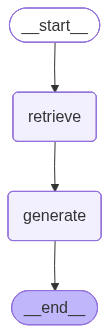

In [104]:
from langgraph.graph import START, StateGraph

builder = StateGraph(mystate)
builder.add_sequence([retrieve,generate])
builder.add_edge(START,"retrieve")
graph = builder.compile()
graph

In [105]:
response = graph.invoke({"question":"what is large cap equity fund?"})
response

{'question': 'what is large cap equity fund?',
 'context': [Document(id='2971241b-b336-4b94-90be-f988a53abc5e', metadata={'page_label': '1', 'moddate': '2021-02-26T12:11:18+05:30', 'author': 'KBelapu', 'producer': 'GPL Ghostscript 9.06', 'creationdate': '2021-02-26T12:11:18+05:30', 'total_pages': 12, 'title': 'Microsoft Word - India Category_Definitions April 2021', 'creator': 'PScript5.dll Version 5.2.2', 'page': 0, 'source': 'https://www.morningstar.in/docs/methodology/CategoryDefinitionsIndiaV3.pdf'}, page_content='? \n \n \n \n \n \n \n \n \n \n \n \nCategor y Definitions  \nIndia \nEquity  \n \nLarge-Cap \nLarge-Cap funds primarily consist of stocks which are the Top 100 stocks by full market capitalization  of \nthe equity market. These funds invest at least 80% of total assets in Indian equities and the balance can \nbe invested in other asset classes such as fixed income and overseas equities, among others. Funds in \nthis category would invest at least 80% of their total asset